# Evaluation Notebook

In [6]:
import pandas as pd
import HpTrainingFrame
from sklearn.metrics import roc_auc_score
from keras.models import model_from_json
from joblib import load,dump
from HpMLUtils import FeatureDivider
from HpMLFeatureNormalisation import WeightedStandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

In [7]:
preregions = ["INC_5j3b","INC_5jge4b","INC_ge6j3b","INC_ge6jge4b"]
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
path = "/data/JulianGlatzer/HplusML/trainall/models/"
bins =50
#IN TRAINING found without inversion, EVEN eventNumber in X_train training the 2mod0
#HERE found EVEN eventNUmber in X_train aswell, should use X_test for 2mod0

In [8]:
roc_aucs_bdt={}
roc_aucs_mpbdt={}
roc_aucs_nn={}
roc_aucs_mpnn={}

roc_aucs_bdt_train={}
roc_aucs_mpbdt_train={}
roc_aucs_nn_train={}
roc_aucs_mpnn_train={}

INC_ge6jge4b
         index  Mbb_MindR_70  eventNumber  Muu_MindR_70  nBTags_70  \
1853266      0   78006.71875     26311789  93472.070312          4   
1853267      1  144572.25000      8057383  86068.453125          4   

         Centrality_all       pT_jet5  dRlepbb_MindR_70    H1_all  \
1853266        0.647530  48389.015625          2.942365  0.428227   
1853267        0.636615  38330.675781          2.980346  0.077838   

            Mjjj_MaxPt  ...  dRbb_avg_70  nJets  Mbb_MaxPt_70       HT_jets  \
1853266  165577.281250  ...     1.836845      6   78006.71875  410279.37500   
1853267  184632.640625  ...     2.357118      6  144572.25000  470684.46875   

           weight  process             group        region        pT_jet1  \
1853266  0.769165  ttlight  t#bar{t} + light  INC_ge6jge4b   94875.250000   
1853267  0.867114  ttlight  t#bar{t} + light  INC_ge6jge4b  158391.453125   

         hpmass  
1853266      -1  
1853267      -1  

[2 rows x 21 columns]
200
Instructions for 

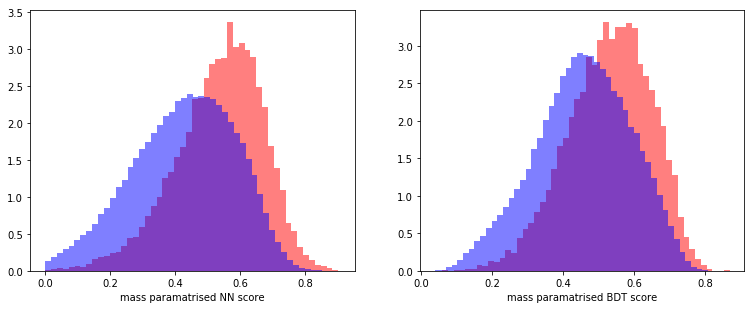

-->NN  mp ROC on train: 0.31916611804487005
-->NN  mp ROC on test : 0.34012839032565967
-->BDT mp ROC on train: 0.32755972300700453
-->BDT mp ROC on test : 0.37550039788533773
-->NN ROC on train: 0.2876484744725414
-->NN ROC on test : 0.32429121095593005
-->BDT ROC on train: 0.22157124725735966
-->BDT ROC on test : 0.32906799877089754

225
(90277, 14) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
(89515, 14) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
(90277, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
(89515, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
NN mp ROC on train: train2mod0 0.32904060727536555
NN mp ROC on test : train2mod0 0.345261987047502
NN ROC on train: train2mod0 0.3157552196274709
NN ROC on test : train2mod0 0.34962255685099086
BDT mp ROC on train: train2mod0 0.3157321350161042
BDT mp ROC on test : train2mod0 0.3605890301199767
BDT ROC on train: train2mod0 0.21579328686568933
BDT ROC 

KeyboardInterrupt: 

In [10]:
for preregion in preregions[-1:]:
    region = preregion if not "5j" in preregion else "5j"
    print(region)
    df_mc=pd.read_hdf('pandas_'+preregion+'.h5', preregion)
    print(df_mc[:2])
    roc_aucs_mpnn_vec=[]
    roc_aucs_mpnn_vec_train=[]
    roc_aucs_nn_vec=[]
    roc_aucs_nn_vec_train=[]
    roc_aucs_mpbdt_vec=[]
    roc_aucs_mpbdt_vec_train=[]
    roc_aucs_bdt_vec=[]
    roc_aucs_bdt_vec_train=[]
    for hpmass in hpmasses:
        htf=HpTrainingFrame.HpTrainingFrame(df_mc)
        X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass,region=preregion,addMass=True)
        print(hpmass)
        y_mpnn=y_test.copy()
        y_mpnn=y_mpnn.append(y_train)
        w_mpnn=w_test.copy()
        w_mpnn=w_mpnn.append(w_train)
        y_mpnn_wtr=y_train.copy()
        y_mpnn_wtr=y_mpnn_wtr.append(y_test)
        w_mpnn_wtr=w_train.copy()
        w_mpnn_wtr=w_mpnn_wtr.append(w_test)
        
        #print("things,",y_mpnn.shape,y_test.shape,y_train.shape)
        for invertTestTrain in [False,True]:
            trainlabel = "train2mod0"
            if invertTestTrain:
                trainlabel="train2mod1"
                X_tmp=X_train.copy()
                y_tmp=y_train.copy()
                w_tmp=w_train.copy()
                X_train=X_test.copy()
                y_train=y_test.copy()
                w_train=w_test.copy()
                X_test=X_tmp
                y_test=y_tmp
                w_test=w_tmp
                
            #load NN training
            nnwss=load(path+'standardNN_'+str(hpmass)+'_'+region+'_'+trainlabel+'_pipe.joblib').steps[1][1]
            json_file = open(path+'standardNN_'+str(hpmass)+'_'+region+'_'+trainlabel+'_architecture.h5')
            loaded_model_json = json_file.read()
            json_file.close()
            nnmodel = model_from_json(loaded_model_json)
            nnmodel.load_weights(path+'standardNN_'+str(hpmass)+'_'+region+'_'+trainlabel+'_weights.h5')
            X_tsnn,y_tsnn,w_tsnn = nnwss.transform(X_test.drop(["hpmass"],axis=1),y_test,w_test)
            X_trnn,y_trnn,w_trnn = nnwss.transform(X_train.drop(["hpmass"],axis=1),y_train,w_train)
            y_tsnn_pred = nnmodel.predict(X_tsnn).ravel()
            y_trnn_pred = nnmodel.predict(X_trnn).ravel()  
            
            #load BDT training
            bdtmodel=load(path+'standardBDT_'+str(hpmass)+'_'+region+'_'+trainlabel+'.joblib')
            y_tsbdt_pred = bdtmodel.predict_proba(X_test.drop(["hpmass"],axis=1))[:,1]
            y_trbdt_pred = bdtmodel.predict_proba(X_train.drop(["hpmass"],axis=1))[:,1]
            
            #load NN mp training
            nnmppipe=load(path+'massparameterisedNN3_'+region+'_'+trainlabel+'_pipe.joblib')
            json_file = open(path+'massparameterisedNN3_'+region+'_'+trainlabel+'_architecture.h5')
            loaded_model_json = json_file.read()
            json_file.close()
            nnmpmodel = model_from_json(loaded_model_json)
            nnmpmodel.load_weights(path+'massparameterisedNN3_'+region+'_'+trainlabel+'_weights.h5')
            nnmpfd=nnmppipe.steps[3][1]
            nnmpwss=nnmppipe.steps[4][1]
            #load BDT mp training
            bdtmppipe=load(path+'massparameterisedBDT_'+region+'_'+trainlabel+'_pipe.joblib')
            bdtmpmodel=load(path+'massparameterisedBDT_'+region+'_'+trainlabel+'_bdt.joblib')
            bdtmpfd=bdtmppipe.steps[-1][1]
            
            #print(X_train.hpmass.unique(), X_train.shape, X_test.shape)
            X_train["hpmass"]=hpmass
            X_test["hpmass"]=hpmass
            X_tsnnmp, y_tsnnmp, w_tsnnmp = nnmpfd.transform(X_test.copy(),y_test,w_test)
            X_trnnmp, y_trnnmp, w_trnnmp = nnmpfd.transform(X_train.copy(),y_train,w_train)
            X_tsnnmp, y_tsnnmp, w_tsnnmp = nnmpwss.transform(X_tsnnmp,y_tsnnmp,w_tsnnmp)
            X_trnnmp, y_trnnmp, w_trnnmp = nnmpwss.transform(X_trnnmp,y_trnnmp,w_trnnmp)
            y_tsnnmp_pred = nnmpmodel.predict(X_tsnnmp).ravel()
            y_trnnmp_pred = nnmpmodel.predict(X_trnnmp).ravel()            
            
            X_tsbdtmp, y_tsbdtmp, w_tsbdtmp = bdtmpfd.transform(X_test.copy(),y_test,w_test)
            X_trbdtmp, y_trbdtmp, w_trbdtmp = bdtmpfd.transform(X_train.copy(),y_train,w_train)
            y_tsbdtmp_pred = bdtmpmodel.predict_proba(X_tsbdtmp)[:,1]
            y_trbdtmp_pred = bdtmpmodel.predict_proba(X_trbdtmp)[:,1]
            
            print ("NN mp ROC on train:", trainlabel, 1.-roc_auc_score(y_trnnmp,y_trnnmp_pred,sample_weight=w_trnnmp))
            print ("NN mp ROC on test :", trainlabel, 1.-roc_auc_score(y_tsnnmp,y_tsnnmp_pred,sample_weight=w_tsnnmp))
            print ("NN ROC on train:", trainlabel, 1.-roc_auc_score(y_trnn,y_trnn_pred,sample_weight=w_trnn))
            print ("NN ROC on test :", trainlabel, 1.-roc_auc_score(y_tsnn,y_tsnn_pred,sample_weight=w_tsnn))
            print ("BDT mp ROC on train:", trainlabel, 1.-roc_auc_score(y_trbdtmp,y_trbdtmp_pred,sample_weight=w_trbdtmp))
            print ("BDT mp ROC on test :", trainlabel, 1.-roc_auc_score(y_tsbdtmp,y_tsbdtmp_pred,sample_weight=w_tsbdtmp))
            print ("BDT ROC on train:", trainlabel, 1.-roc_auc_score(y_trbdtmp,y_trbdt_pred,sample_weight=w_train))
            print ("BDT ROC on test :", trainlabel, 1.-roc_auc_score(y_tsbdtmp,y_tsbdt_pred,sample_weight=w_test))
            
            if not invertTestTrain:
                y_mpnn_pred=y_tsnnmp_pred.copy()
                y_mpnn_pred_wtr=y_trnnmp_pred.copy()
                y_nn_pred=y_tsnn_pred.copy()
                y_nn_pred_wtr=y_trnn_pred.copy()
                y_mpbdt_pred=y_tsbdtmp_pred.copy()
                y_mpbdt_pred_wtr=y_trbdtmp_pred.copy()
                y_bdt_pred=y_tsbdt_pred.copy()
                y_bdt_pred_wtr=y_trbdt_pred.copy()
            else:
                y_mpnn_pred = np.append(y_mpnn_pred,y_tsnnmp_pred)
                y_mpnn_pred_wtr = np.append(y_mpnn_pred_wtr,y_trnnmp_pred)
                y_nn_pred = np.append(y_nn_pred,y_tsnn_pred)
                y_nn_pred_wtr = np.append(y_nn_pred_wtr,y_trnn_pred)
                y_mpbdt_pred = np.append(y_mpbdt_pred,y_tsbdtmp_pred)
                y_mpbdt_pred_wtr = np.append(y_mpbdt_pred_wtr,y_trbdtmp_pred)
                y_bdt_pred = np.append(y_bdt_pred,y_tsbdt_pred)
                y_bdt_pred_wtr = np.append(y_bdt_pred_wtr,y_trbdt_pred)

            if len(y_mpnn_pred)==y_mpnn.shape[0]:
                
                plt.figure(figsize=(12.8,4.8))
                plt.subplot(1, 2, 1)
                print (type(y_mpnn_pred),type(y_mpnn),type(y_mpbdt_pred),y_mpnn_pred.shape,y_mpnn.shape,y_mpbdt_pred.shape)
                plt.hist(y_mpnn_pred[y_mpnn>0.5],alpha=0.5,color='r',bins=bins, density=True)
                plt.hist(y_mpnn_pred[y_mpnn<0.5],alpha=0.5,color='b',bins=bins, density=True)
                plt.xlabel("mass paramatrised NN score")
                plt.subplot(1, 2, 2)
                plt.hist(y_mpbdt_pred[y_mpnn>0.5],alpha=0.5,color='r',bins=bins, density=True)
                plt.hist(y_mpbdt_pred[y_mpnn<0.5],alpha=0.5,color='b',bins=bins, density=True)
                plt.xlabel("mass paramatrised BDT score" )
                #plt.hist(y_mpbdt_pred_wtr[y_mpbdt_wtr>0.5].ravel(),alpha=0.5,color='r',bins=bins, density=True)
                #plt.hist(y_mpbdt_pred_wtr[y_mpbdt_wtr<0.5].ravel(),alpha=0.5,color='b',bins=bins, density=True)
                #plt.xlabel("mass paramatrised BDT score using train data")
                plt.show()
                
                roc_aucs_mpnn_vec_train.append(1.-roc_auc_score(y_mpnn_wtr,y_mpnn_pred_wtr,sample_weight=w_mpnn_wtr))
                roc_aucs_mpnn_vec.append(1.-roc_auc_score(y_mpnn,y_mpnn_pred,sample_weight=w_mpnn))
                roc_aucs_mpbdt_vec_train.append(1.-roc_auc_score(y_mpnn_wtr,y_mpbdt_pred_wtr,sample_weight=w_mpnn_wtr))
                roc_aucs_mpbdt_vec.append(1.-roc_auc_score(y_mpnn,y_mpbdt_pred,sample_weight=w_mpnn))
                roc_aucs_bdt_vec_train.append(1.-roc_auc_score(y_mpnn_wtr,y_bdt_pred_wtr,sample_weight=w_mpnn_wtr))
                roc_aucs_bdt_vec.append(1.-roc_auc_score(y_mpnn,y_bdt_pred,sample_weight=w_mpnn))
                roc_aucs_nn_vec_train.append(1.-roc_auc_score(y_mpnn_wtr,y_nn_pred_wtr,sample_weight=w_mpnn_wtr))
                roc_aucs_nn_vec.append(1.-roc_auc_score(y_mpnn,y_nn_pred,sample_weight=w_mpnn))
                print ("-->NN  mp ROC on train:", roc_aucs_mpnn_vec_train[-1])
                print ("-->NN  mp ROC on test :", roc_aucs_mpnn_vec[-1])
                print ("-->BDT mp ROC on train:", roc_aucs_mpbdt_vec_train[-1])
                print ("-->BDT mp ROC on test :", roc_aucs_mpbdt_vec[-1])
                print ("-->NN ROC on train:", roc_aucs_nn_vec_train[-1])
                print ("-->NN ROC on test :", roc_aucs_nn_vec[-1])
                print ("-->BDT ROC on train:", roc_aucs_bdt_vec_train[-1])
                print ("-->BDT ROC on test :", roc_aucs_bdt_vec[-1])
                print ("")
    roc_aucs_mpnn[preregion]=roc_aucs_mpnn_vec
    roc_aucs_mpnn_train[preregion]=roc_aucs_mpnn_vec_train
    roc_aucs_mpbdt[preregion]=roc_aucs_mpbdt_vec
    roc_aucs_mpbdt_train[preregion]=roc_aucs_mpbdt_vec_train
    roc_aucs_bdt[preregion]=roc_aucs_bdt_vec
    roc_aucs_bdt_train[preregion]=roc_aucs_bdt_vec_train
    roc_aucs_nn[preregion]=roc_aucs_nn_vec
    roc_aucs_nn_train[preregion]=roc_aucs_nn_vec_train
    print("BDT:",roc_aucs_bdt)
    print("BDT mp:",roc_aucs_mpbdt)
    print("NN mp:",roc_aucs_mpnn)
    print("NN:",roc_aucs_nn)
print (roc_aucs_mpnn)
    
                


In [5]:
dump(roc_aucs_mpnn,"roc_aucs_mpnn_allregions")
dump(roc_aucs_nn,"roc_aucs_nn_allregions")
dump(roc_aucs_mpbdt,"roc_aucs_mpbdt_allregions")
dump(roc_aucs_bdt,"roc_aucs_bdt_allregions")

dump(roc_aucs_mpnn_train,"roc_aucs_mpnn_allregions_train")
dump(roc_aucs_nn_train,"roc_aucs_nn_allregions_train")
dump(roc_aucs_mpbdt_train,"roc_aucs_mpbdt_allregions_train")
dump(roc_aucs_bdt_train,"roc_aucs_bdt_allregions_train")

['roc_aucs_bdt_allregions_train']

MP-NN
INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


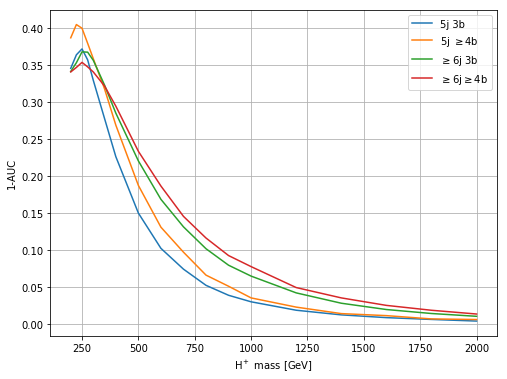

INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


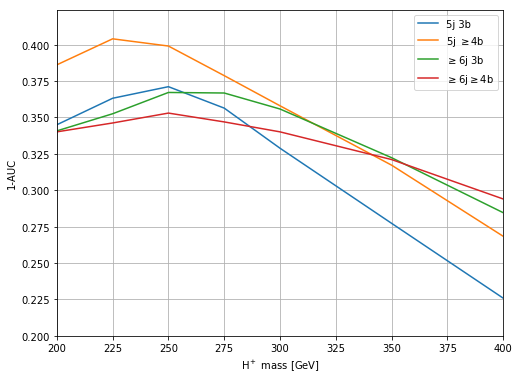

NN
INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


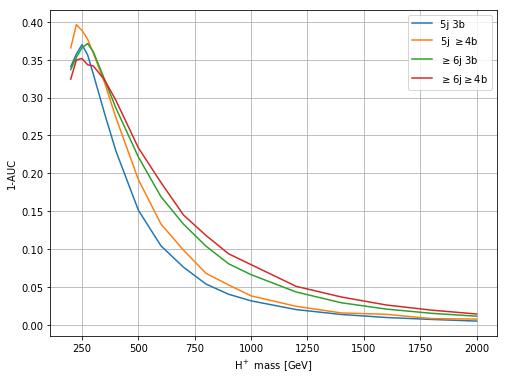

INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


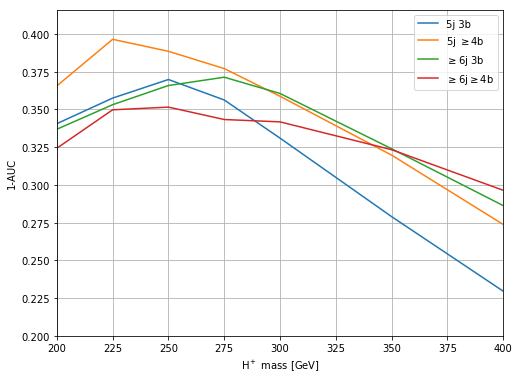

MP-BDT
INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


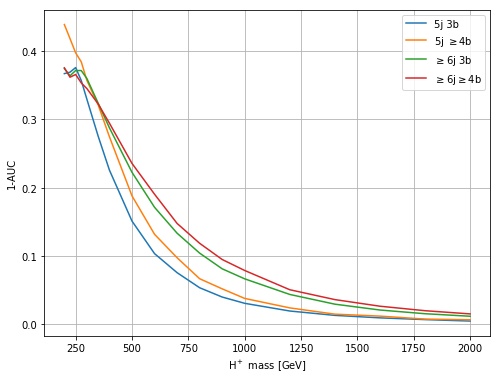

INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


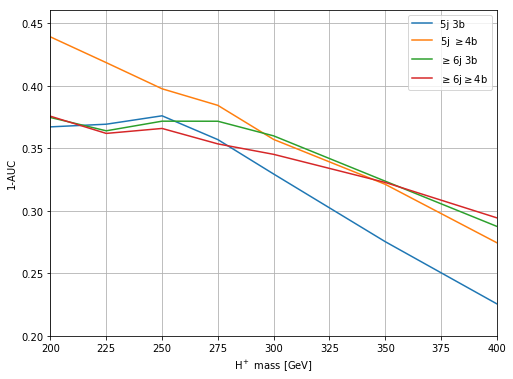

BDT
INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


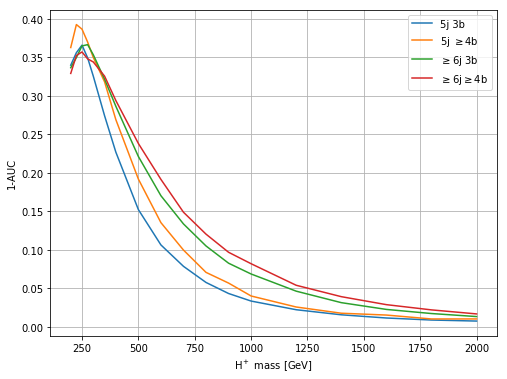

INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


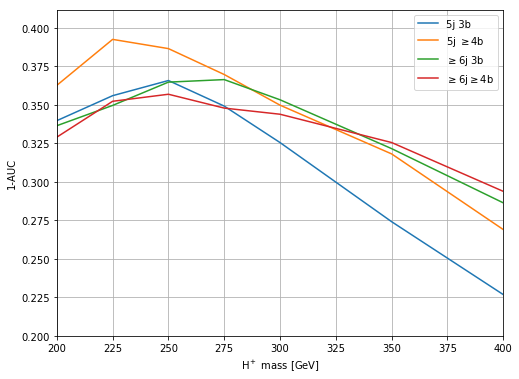

In [25]:
#dump(roc_aucs_mpnn,"roc_aucs_mpnn_allregions")
#dump(roc_aucs_mpnn_train,"roc_aucs_mpnn_allregions_train")
#roc_aucs_mpnn=load("roc_aucs_mpnn_allregions")
labels = ["5j 3b","5j "+r'$\geq$'+"4b",r'$\geq6$j'+" 3b", r'$\geq6$j$\geq$4b']
objects = [roc_aucs_mpnn,roc_aucs_nn,roc_aucs_mpbdt,roc_aucs_bdt]
nameobjects = ["MP-NN", "NN", "MP-BDT", "BDT"]
for clf,nameclf in zip(objects,nameobjects):
    print (nameclf)
    plt.figure(figsize=(8,6))
    for region,label in zip(preregions,labels):
        print (region, label)
        plt.plot(hpmasses,clf[region],label=label)
    plt.legend(loc="best")
    plt.xlabel(r'H$^+$ mass [GeV]')
    plt.ylabel("1-AUC")
    plt.grid()
    plt.savefig('results/'+nameclf+'.png')
    plt.show()
    plt.figure(figsize=(8,6))
    for region,label in zip(preregions,labels):
        print (region, label)
        plt.plot(hpmasses,clf[region],label=label)
        plt.xlim(200,400)
    plt.gca().set_ylim(bottom=0.2)
    plt.legend(loc="best")
    plt.xlabel(r'H$^+$ mass [GeV]')
    plt.ylabel("1-AUC")
    plt.grid()
    plt.savefig('results/'+nameclf+'_low.png')
    plt.show()
    

MP-NN
NN
MP-BDT
BDT


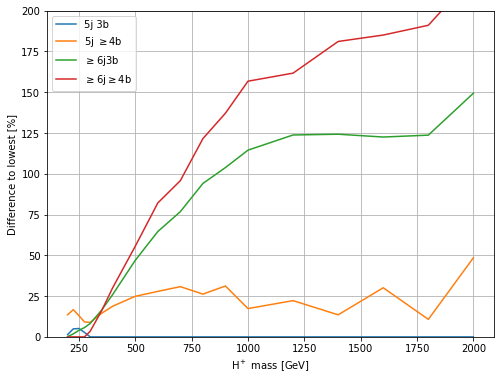

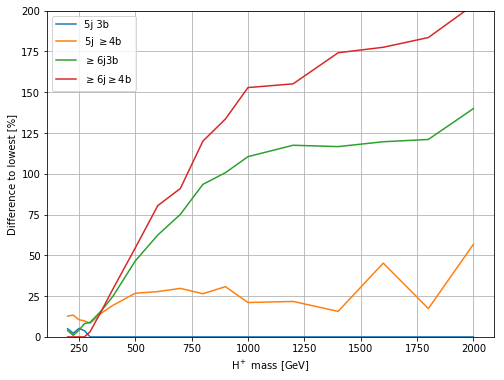

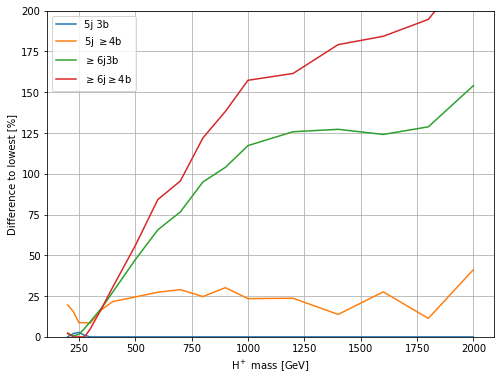

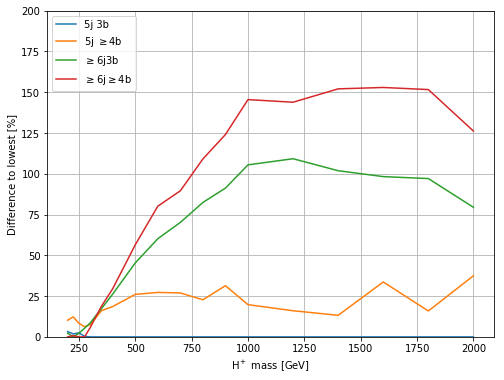

In [26]:
def plotrelative(classifiers,suff, xlow=None, xhigh=None):
  plt.figure(figsize=(8,6))
    
  bdttest=classifiers[0]
  bdtmassparamtest=classifiers[1]
  nntest=classifiers[2]
  nnmassparamtest=classifiers[3]
    
  arrays=[]
  
  ratiobdt=[]
  ratiobdtmassparam=[]
  rationn=[]
  rationnmassparam=[]
  ratios=[[] for _ in range(4)]
  for i in range(len(hpmasses)):
    values=[bdttest[i],bdtmassparamtest[i],nntest[i],nnmassparamtest[i]]
    for arr in arrays:
      values.append(arr[i])
    mn=min(values)
    ratiobdt.append((bdttest[i]-mn)/mn*100)
    ratiobdtmassparam.append((bdtmassparamtest[i]-mn)/mn*100)
    rationn.append((nntest[i]-mn)/mn*100)
    rationnmassparam.append((nnmassparamtest[i]-mn)/mn*100)
    for j,arr in enumerate(arrays):
      ratios[j].append((arr[i]-mn)/mn*100)
      
  color=iter(plt.cm.rainbow(np.linspace(0,1,4+len(arrays))))
  plt.plot(hpmasses, ratiobdt, label="5j 3b")
  plt.plot(hpmasses, ratiobdtmassparam, label=r"5j $\geq$4b")
  plt.plot(hpmasses, rationn, label=r"$\geq$6j3b")
  plt.plot(hpmasses, rationnmassparam, label=r"$\geq$6j$\geq$4b")
  #for label,ratio in zip(labels,ratios):
  #  print("L/R:",label, len(ratio))
  #  plt.plot(hpmasses, ratio, '--', color=next(color), label=label)
  plt.ylabel("Difference to lowest [%]")
  plt.xlabel(r'H$^+$ mass [GeV]')
  if not xlow is None and not xhigh is None:
    plt.xlim((xlow, xhigh))
  plt.ylim((0.,200.))
  plt.grid()
  plt.legend()
  plt.savefig('results/'+suff+'_rel.png')

for obj,name in zip(objects,nameobjects):
    print (name)
    plotrelative([obj["INC_5j3b"],obj["INC_5jge4b"],obj["INC_ge6j3b"],obj["INC_ge6jge4b"]],name)
    

MP-NN
NN
MP-BDT
BDT


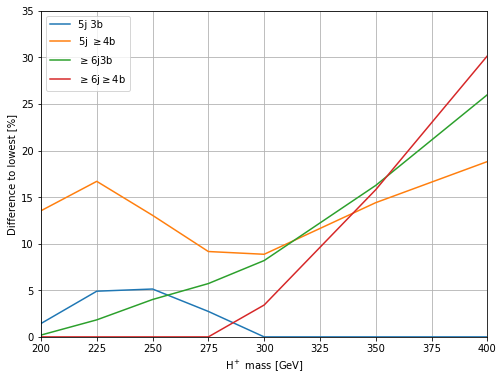

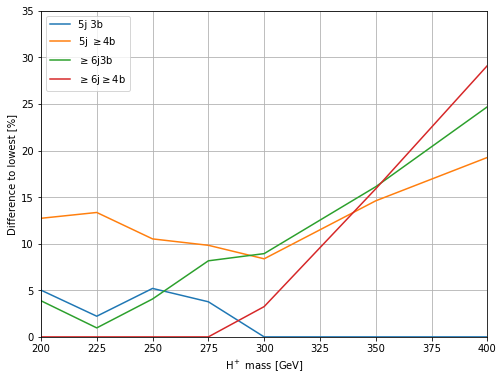

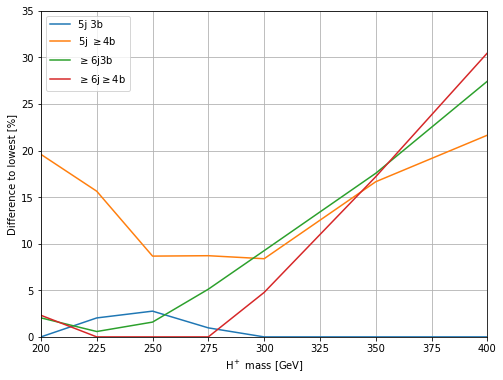

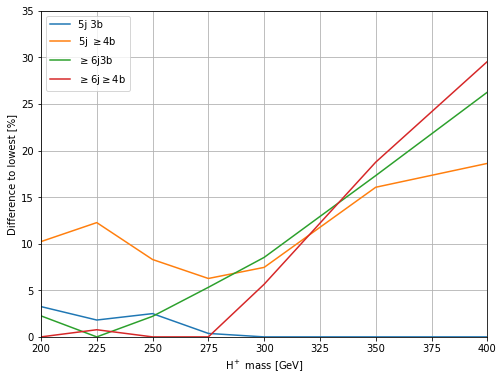

In [29]:
def plotrelative(classifiers,suff, xlow=200, xhigh=400):
  plt.figure(figsize=(8,6))
    
  bdttest=classifiers[0]
  bdtmassparamtest=classifiers[1]
  nntest=classifiers[2]
  nnmassparamtest=classifiers[3]
    
  arrays=[]
  
  ratiobdt=[]
  ratiobdtmassparam=[]
  rationn=[]
  rationnmassparam=[]
  ratios=[[] for _ in range(4)]
  for i in range(len(hpmasses)):
    values=[bdttest[i],bdtmassparamtest[i],nntest[i],nnmassparamtest[i]]
    for arr in arrays:
      values.append(arr[i])
    mn=min(values)
    ratiobdt.append((bdttest[i]-mn)/mn*100)
    ratiobdtmassparam.append((bdtmassparamtest[i]-mn)/mn*100)
    rationn.append((nntest[i]-mn)/mn*100)
    rationnmassparam.append((nnmassparamtest[i]-mn)/mn*100)
    for j,arr in enumerate(arrays):
      ratios[j].append((arr[i]-mn)/mn*100)
      
  color=iter(plt.cm.rainbow(np.linspace(0,1,4+len(arrays))))
  plt.plot(hpmasses, ratiobdt, label="5j 3b")
  plt.plot(hpmasses, ratiobdtmassparam, label=r"5j $\geq$4b")
  plt.plot(hpmasses, rationn, label=r"$\geq$6j3b")
  plt.plot(hpmasses, rationnmassparam, label=r"$\geq$6j$\geq$4b")
  #for label,ratio in zip(labels,ratios):
  #  print("L/R:",label, len(ratio))
  #  plt.plot(hpmasses, ratio, '--', color=next(color), label=label)
  plt.ylabel("Difference to lowest [%]")
  plt.xlabel(r'H$^+$ mass [GeV]')
  if not xlow is None and not xhigh is None:
    plt.xlim((xlow, xhigh))
  plt.ylim((0.,35.))
  plt.grid()
  plt.legend()
  plt.savefig('results/'+suff+'_rel_low.png')


for obj,name in zip(objects,nameobjects):
    print (name)
    plotrelative([obj["INC_5j3b"],obj["INC_5jge4b"],obj["INC_ge6j3b"],obj["INC_ge6jge4b"]],name)
    

5j 3b
Standard BDT
MP-BDT
Standard NN
MP-NN


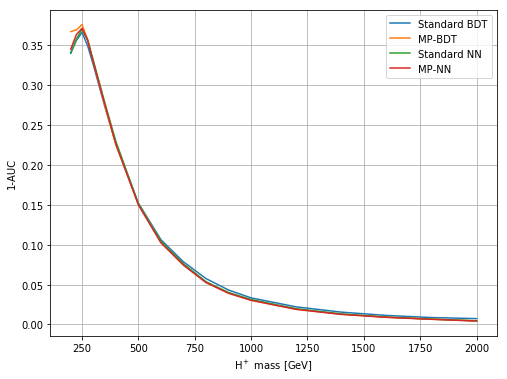

Standard BDT
MP-BDT
Standard NN
MP-NN


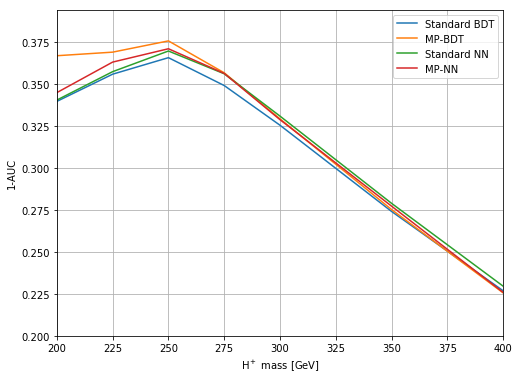

5j $\geq$4b
Standard BDT
MP-BDT
Standard NN
MP-NN


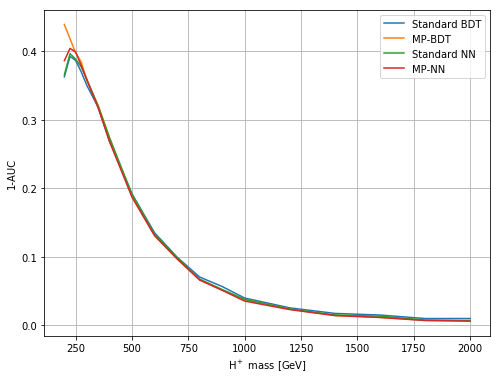

Standard BDT
MP-BDT
Standard NN
MP-NN


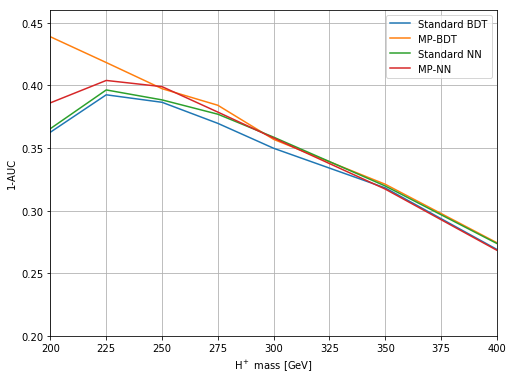

$\geq6$j 3b
Standard BDT
MP-BDT
Standard NN
MP-NN


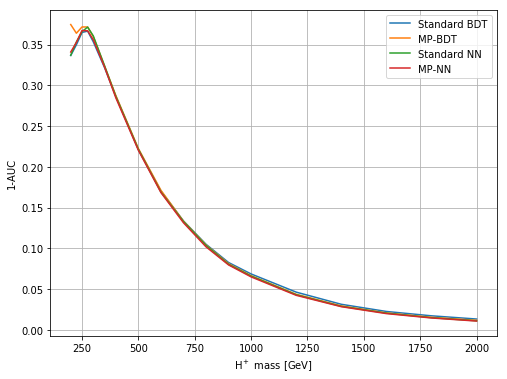

Standard BDT
MP-BDT
Standard NN
MP-NN


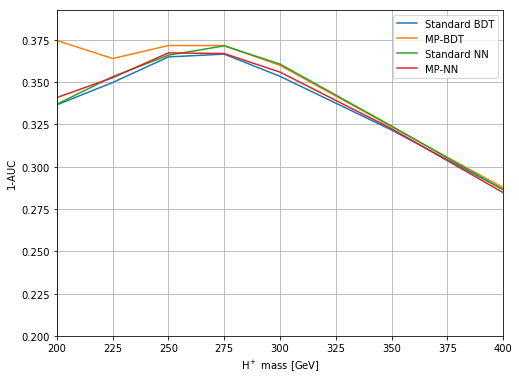

$\geq6$j$\geq$4b
Standard BDT
MP-BDT
Standard NN
MP-NN


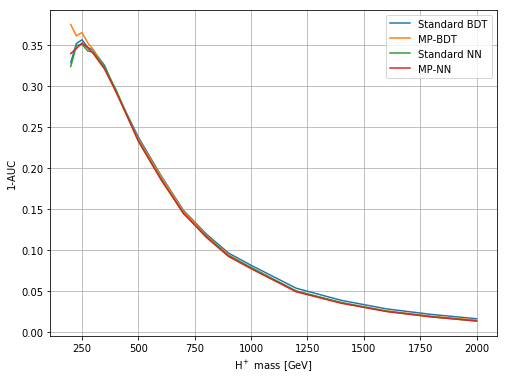

Standard BDT
MP-BDT
Standard NN
MP-NN


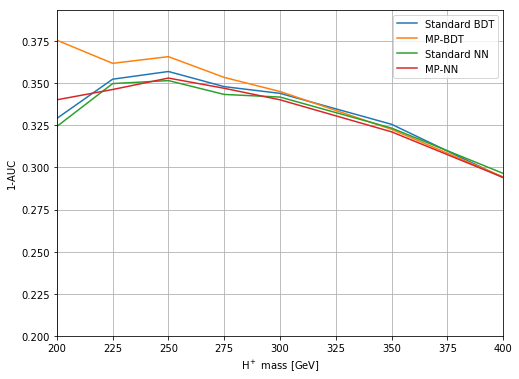

In [7]:
#dump(roc_aucs_mpnn,"roc_aucs_mpnn_allregions")
#dump(roc_aucs_mpnn_train,"roc_aucs_mpnn_allregions_train")
#roc_aucs_mpnn=load("roc_aucs_mpnn_allregions")
labels = ["5j 3b","5j "+r'$\geq$'+"4b",r'$\geq6$j'+" 3b", r'$\geq6$j$\geq$4b']
objects = [roc_aucs_bdt,roc_aucs_mpbdt,roc_aucs_nn,roc_aucs_mpnn]
nameobjects = ["Standard BDT", "MP-BDT", "Standard NN", "MP-NN"]
for region, label in zip(preregions,labels):
    print (label)
    plt.figure(figsize=(8,6))
    for clf,nameclf in zip(objects,nameobjects):
        print (nameclf)
        plt.plot(hpmasses,clf[region],label=nameclf)
    plt.legend(loc="best")
    plt.xlabel(r'H$^+$ mass [GeV]')
    plt.ylabel("1-AUC")
    plt.grid()
    plt.savefig('results/'+region+'.png') 
    plt.show()
    plt.figure(figsize=(8,6))
    for clf,nameclf in zip(objects,nameobjects):
        print (nameclf)
        plt.plot(hpmasses,clf[region],label=nameclf)
        plt.xlim(200,400)
    plt.gca().set_ylim(bottom=0.2)
    plt.legend(loc="best")
    plt.xlabel(r'H$^+$ mass [GeV]')
    plt.ylabel("1-AUC")
    plt.grid()
    plt.savefig('results/'+region+'_low.png')
    plt.show()


INC_5j3b
INC_5jge4b
INC_ge6j3b
INC_ge6jge4b


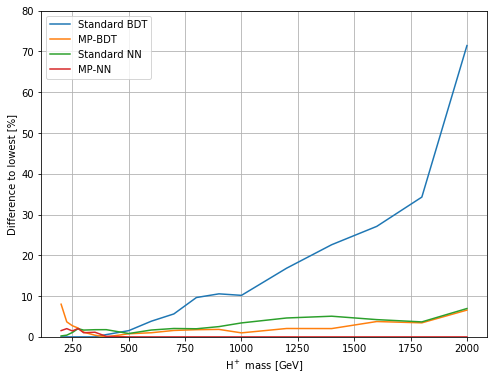

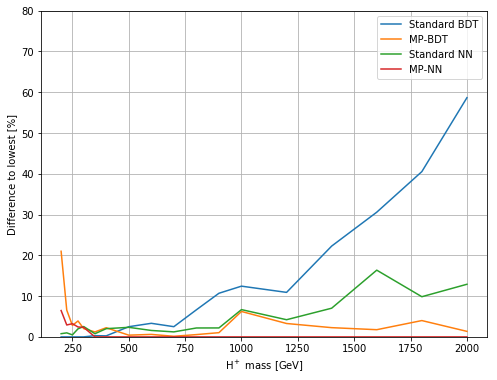

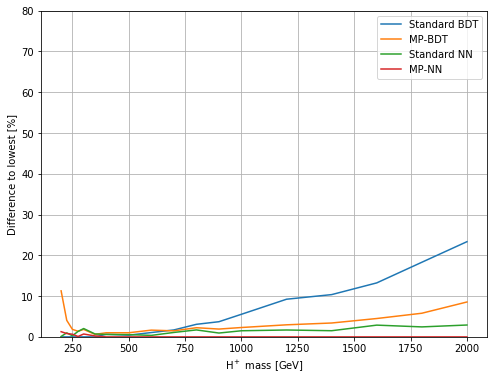

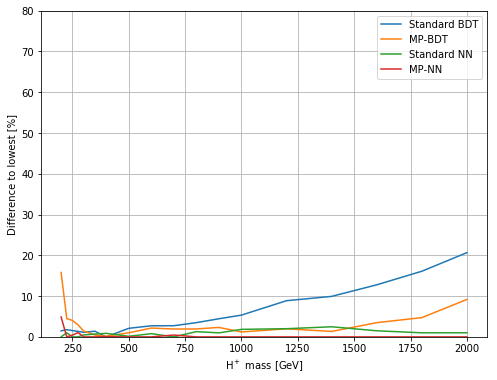

In [8]:
def plotrelative(classifiers,suff, xlow=None, xhigh=None):
  plt.figure(figsize=(8,6))
    
  bdttest=classifiers[0]
  bdtmassparamtest=classifiers[1]
  nntest=classifiers[2]
  nnmassparamtest=classifiers[3]
    
  arrays=[]
  
  ratiobdt=[]
  ratiobdtmassparam=[]
  rationn=[]
  rationnmassparam=[]
  ratios=[[] for _ in range(4)]
  for i in range(len(hpmasses)):
    values=[bdttest[i],bdtmassparamtest[i],nntest[i],nnmassparamtest[i]]
    for arr in arrays:
      values.append(arr[i])
    mn=min(values)
    ratiobdt.append((bdttest[i]-mn)/mn*100)
    ratiobdtmassparam.append((bdtmassparamtest[i]-mn)/mn*100)
    rationn.append((nntest[i]-mn)/mn*100)
    rationnmassparam.append((nnmassparamtest[i]-mn)/mn*100)
    for j,arr in enumerate(arrays):
      ratios[j].append((arr[i]-mn)/mn*100)
      
  color=iter(plt.cm.rainbow(np.linspace(0,1,4+len(arrays))))
  plt.plot(hpmasses, ratiobdt, label="Standard BDT")
  plt.plot(hpmasses, ratiobdtmassparam, label="MP-BDT")
  plt.plot(hpmasses, rationn, label="Standard NN")
  plt.plot(hpmasses, rationnmassparam, label="MP-NN")
  #for label,ratio in zip(labels,ratios):
  #  print("L/R:",label, len(ratio))
  #  plt.plot(hpmasses, ratio, '--', color=next(color), label=label)
  plt.ylabel("Difference to lowest [%]")
  plt.xlabel(r'H$^+$ mass [GeV]')
  if not xlow is None and not xhigh is None:
    plt.xlim((xlow, xhigh))
  plt.ylim((0.,80.))
  plt.grid()
  plt.legend()
  plt.savefig('results/'+suff+'_rel.png')


for ireg in preregions:
    print (ireg)
    plotrelative([roc_aucs_bdt[ireg],roc_aucs_mpbdt[ireg],roc_aucs_nn[ireg],roc_aucs_mpnn[ireg]],ireg)


INC_5j3b
INC_5jge4b
INC_ge6j3b
INC_ge6jge4b


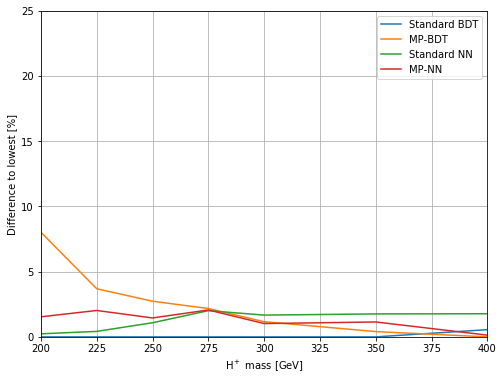

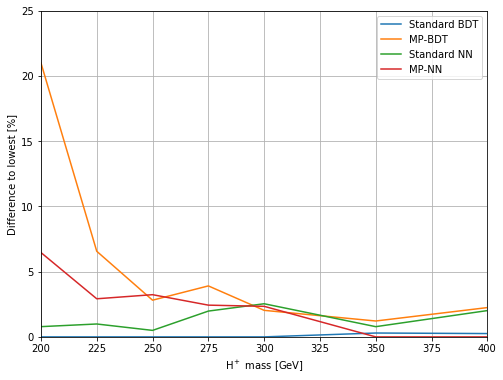

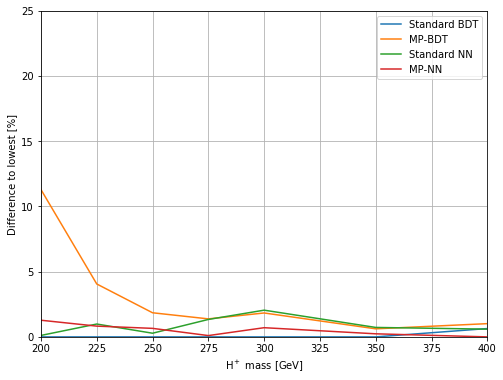

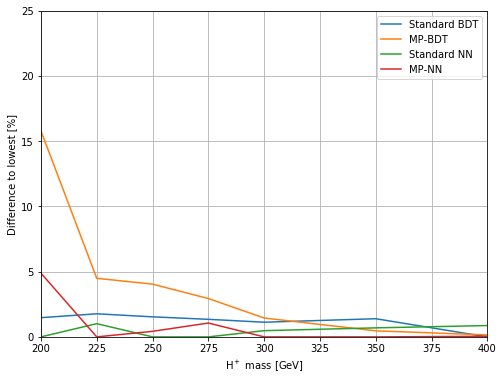

In [10]:
def plotrelative(classifiers,suff, xlow=200, xhigh=400):
  plt.figure(figsize=(8,6))
    
  bdttest=classifiers[0]
  bdtmassparamtest=classifiers[1]
  nntest=classifiers[2]
  nnmassparamtest=classifiers[3]
    
  arrays=[]
  
  ratiobdt=[]
  ratiobdtmassparam=[]
  rationn=[]
  rationnmassparam=[]
  ratios=[[] for _ in range(4)]
  for i in range(len(hpmasses)):
    values=[bdttest[i],bdtmassparamtest[i],nntest[i],nnmassparamtest[i]]
    for arr in arrays:
      values.append(arr[i])
    mn=min(values)
    ratiobdt.append((bdttest[i]-mn)/mn*100)
    ratiobdtmassparam.append((bdtmassparamtest[i]-mn)/mn*100)
    rationn.append((nntest[i]-mn)/mn*100)
    rationnmassparam.append((nnmassparamtest[i]-mn)/mn*100)
    for j,arr in enumerate(arrays):
      ratios[j].append((arr[i]-mn)/mn*100)
      
  color=iter(plt.cm.rainbow(np.linspace(0,1,4+len(arrays))))
  plt.plot(hpmasses, ratiobdt, label="Standard BDT")
  plt.plot(hpmasses, ratiobdtmassparam, label="MP-BDT")
  plt.plot(hpmasses, rationn, label="Standard NN")
  plt.plot(hpmasses, rationnmassparam, label="MP-NN")
  #for label,ratio in zip(labels,ratios):
  #  print("L/R:",label, len(ratio))
  #  plt.plot(hpmasses, ratio, '--', color=next(color), label=label)
  plt.ylabel("Difference to lowest [%]")
  plt.xlabel(r'H$^+$ mass [GeV]')
  if not xlow is None and not xhigh is None:
    plt.xlim((xlow, xhigh))
  plt.ylim((0.,25.))
  plt.grid()
  plt.legend()
  plt.savefig('results/'+suff+'_rel_low.png')


for ireg in preregions:
    print (ireg)
    plotrelative([roc_aucs_bdt[ireg],roc_aucs_mpbdt[ireg],roc_aucs_nn[ireg],roc_aucs_mpnn[ireg]],ireg)


INC_5j3b 5j 3b
INC_5jge4b 5j $\geq$4b
INC_ge6j3b $\geq6$j 3b
INC_ge6jge4b $\geq6$j$\geq$4b


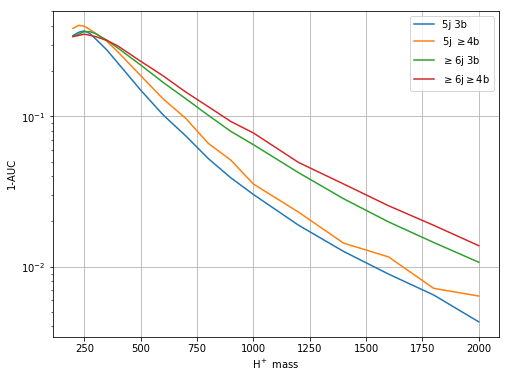

In [18]:
roc_aucs_mpnn=load("roc_aucs_mpnn_allregions")
plt.figure(figsize=(8,6))
labels = ["5j 3b","5j "+r'$\geq$'+"4b",r'$\geq6$j'+" 3b", r'$\geq6$j$\geq$4b']
for region,label in zip(preregions,labels):
    print (region, label)
    plt.semilogy(hpmasses,roc_aucs_mpnn[region],label=label)
plt.legend(loc="best")
plt.xlabel(r'H$^+$ mass')
plt.ylabel("1-AUC")
plt.grid()
plt.show()

In [87]:
#load training
mpwss=load(path+'massparameterisedNN3_'+region+'_'+trainlabel+'_pipe.joblib')
json_file = open(path+'massparameterisedNN3_'+region+'_'+trainlabel+'_architecture.h5')
loaded_model_json = json_file.read()
json_file.close()
nnmpmodel = model_from_json(loaded_model_json)
nnmpmodel.load_weights(path+'massparameterisedNN3_'+region+'_'+trainlabel+'_weights.h5')

In [86]:
trainlabel='train2mod0'

In [88]:
#load data
df_mc=pd.read_hdf('pandas_'+preregion+'.h5',preregion)
htf=HpTrainingFrame.HpTrainingFrame(df_mc)

In [89]:
df_mc.head()

,index,Mbb_MindR_70,eventNumber,Muu_MindR_70,nBTags_70,Centrality_all,pT_jet5,dRlepbb_MindR_70,H1_all,Mjjj_MaxPt,...,dRbb_avg_70,nJets,Mbb_MaxPt_70,HT_jets,weight,process,group,region,pT_jet1,hpmass
1853266,0,78006.718750,26311789,93472.070312,4,0.647530,48389.015625,2.942365,0.428227,165577.281250,...,1.836845,6,78006.718750,410279.37500,0.769165,ttlight,t#bar{t} + light,INC_ge6jge4b,94875.250000,-1
1853267,1,144572.250000,8057383,86068.453125,4,0.636615,38330.675781,2.980346,0.077838,184632.640625,...,2.357118,6,144572.250000,470684.46875,0.867114,ttlight,t#bar{t} + light,INC_ge6jge4b,158391.453125,-1
1853268,2,45798.390625,21899308,283880.406250,4,0.649095,72458.781250,1.807999,0.004904,153976.984375,...,1.430680,6,81811.507812,577440.87500,0.660478,ttlight,t#bar{t} + light,INC_ge6jge4b,182397.343750,-1
1853269,3,68210.140625,18972816,156986.078125,4,0.663991,33645.386719,3.255158,0.019155,251311.531250,...,2.663929,7,152639.437500,424901.68750,0.605552,ttlight,t#bar{t} + light,INC_ge6jge4b,154738.656250,-1
1853270,4,67664.296875,11299806,43554.640625,4,0.743293,45294.984375,3.130159,0.119582,156184.890625,...,1.951383,6,98741.585938,371469.62500,0.350783,ttlight,t#bar{t} + light,INC_ge6jge4b,94807.296875,-1


In [112]:
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass,region=preregion)
X_train.columns

Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all'],
      dtype='object')

In [113]:
X_train["hpmass"]=hpmass
X_train.head()

,nJets,nBTags_70,pT_jet1,Mbb_MindR_70,pT_jet5,H1_all,dRbb_avg_70,dRlepbb_MindR_70,Muu_MindR_70,HT_jets,Mbb_MaxPt_70,Mbb_MaxM_70,Mjjj_MaxPt,Centrality_all,hpmass
127016,7,4,220453.562500,161892.046875,40550.882812,0.695542,2.164872,2.158286,69633.101562,5.962589e+05,161892.046875,199849.21875,244667.796875,0.478771,225
46673,7,4,73611.703125,58556.890625,32913.500000,0.339149,1.839673,2.636916,61758.414062,3.203006e+05,58556.890625,159747.31250,110880.210938,0.601378,225
172176,6,4,167313.484375,91626.390625,26928.994141,0.028552,2.117638,2.952598,379031.843750,6.236944e+05,91626.390625,289026.28125,185498.265625,0.594196,225
30952,6,4,184366.625000,63248.535156,40172.015625,0.541511,2.248982,2.936186,90653.140625,5.179224e+05,63248.535156,413818.03125,190354.781250,0.526309,225
130341,9,4,457357.156250,114795.343750,99600.515625,0.302717,1.513713,0.791567,15985.627930,1.501724e+06,189358.359375,546578.12500,249761.062500,0.748789,225


In [115]:
print(mpwss.steps)
fd=mpwss.steps[3][1]
wss=mpwss.steps[4][1]
print (fd,wss)

[('msb', <HpMLWeightTransformer.MultiSBWeightsScaler object at 0x7f64b9c3f7b8>), ('scl', <HpMLWeightTransformer.WeightsMultiplier object at 0x7f64b9c3f828>), ('aug', <HpMLMTL.HpMTLBackgroundAugmenter object at 0x7f64b8054e80>), ('fd', <HpMLUtils.FeatureDivider object at 0x7f64b8054cc0>), ('wss', WeightedStandardScaler(copy=True, with_mean=True, with_std=True))]
<HpMLUtils.FeatureDivider object at 0x7f64b8054cc0> WeightedStandardScaler(copy=True, with_mean=True, with_std=True)


In [116]:
X_tr, y_tr, w_tr = fd.transform(X_train,y_train,w_train)

In [94]:
print(X_tr.columns, len(X_tr.columns))

Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all', 'hpmass',
       'pT_jet1divhpmass', 'Mbb_MindR_70divhpmass', 'pT_jet5divhpmass',
       'H1_alldivhpmass', 'dRbb_avg_70divhpmass', 'dRlepbb_MindR_70divhpmass',
       'Muu_MindR_70divhpmass', 'HT_jetsdivhpmass', 'Mbb_MaxPt_70divhpmass',
       'Mbb_MaxM_70divhpmass', 'Mjjj_MaxPtdivhpmass',
       'Centrality_alldivhpmass'],
      dtype='object') 27


In [95]:
X_tr.head()


,nJets,nBTags_70,pT_jet1,Mbb_MindR_70,pT_jet5,H1_all,dRbb_avg_70,dRlepbb_MindR_70,Muu_MindR_70,HT_jets,...,pT_jet5divhpmass,H1_alldivhpmass,dRbb_avg_70divhpmass,dRlepbb_MindR_70divhpmass,Muu_MindR_70divhpmass,HT_jetsdivhpmass,Mbb_MaxPt_70divhpmass,Mbb_MaxM_70divhpmass,Mjjj_MaxPtdivhpmass,Centrality_alldivhpmass
127016,7,4,220453.562500,161892.046875,40550.882812,0.695542,2.164872,2.158286,69633.101562,5.962589e+05,...,180.226146,0.003091,0.009622,0.009592,309.480451,2650.039444,719.520208,888.218750,1087.412431,0.002128
46673,7,4,73611.703125,58556.890625,32913.500000,0.339149,1.839673,2.636916,61758.414062,3.203006e+05,...,146.282222,0.001507,0.008176,0.011720,274.481840,1423.558333,260.252847,709.988056,492.800937,0.002673
172176,6,4,167313.484375,91626.390625,26928.994141,0.028552,2.117638,2.952598,379031.843750,6.236944e+05,...,119.684418,0.000127,0.009412,0.013123,1684.585972,2771.975278,407.228403,1284.561250,824.436736,0.002641
30952,6,4,184366.625000,63248.535156,40172.015625,0.541511,2.248982,2.936186,90653.140625,5.179224e+05,...,178.542292,0.002407,0.009995,0.013050,402.902847,2301.877222,281.104601,1839.191250,846.021250,0.002339
130341,9,4,457357.156250,114795.343750,99600.515625,0.302717,1.513713,0.791567,15985.627930,1.501724e+06,...,442.668958,0.001345,0.006728,0.003518,71.047235,6674.327222,841.592708,2429.236111,1110.049167,0.003328


In [96]:
X_tr, y_tr, w_tr = wss.transform(X_tr,y_tr,w_tr)

(89515, 27) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


In [123]:
print('{')
print('  "inputs": [')
for feat,mean,scale in zip(X_tr.columns,wss.mean_,wss.scale_):
    print('    {')
    print('      "name": "'+feat+'" ,')
    print('      "offset":',-mean,",")
    print('       "scale":',1./scale,"")
    #print (feat,"\t",-mean,1./scale)
    if feat==X_tr.columns[-1]: print('    }')
    else: print('    },')
print('  ],')
print('  "class_labels": ["Example"]')
print('}')

{
  "inputs": [
    {
      "name": "nJets" ,
      "offset": -7.271471140040663 ,
       "scale": 0.7320164751750567 
    },
    {
      "name": "nBTags_70" ,
      "offset": -4.084819928477077 ,
       "scale": 3.335179391016935 
    },
    {
      "name": "pT_jet1" ,
      "offset": -263711.390030526 ,
       "scale": 4.896793773093891e-06 
    },
    {
      "name": "Mbb_MindR_70" ,
      "offset": -104374.3010229407 ,
       "scale": 1.1740670014507783e-05 
    },
    {
      "name": "pT_jet5" ,
      "offset": -60617.33042192924 ,
       "scale": 3.242194881114369e-05 
    },
    {
      "name": "H1_all" ,
      "offset": -0.20190117962790796 ,
       "scale": 4.971517549859531 
    },
    {
      "name": "dRbb_avg_70" ,
      "offset": -2.3204342477620883 ,
       "scale": 2.546160405627756 
    },
    {
      "name": "dRlepbb_MindR_70" ,
      "offset": -2.231133586138163 ,
       "scale": 1.0809777320607759 
    },
    {
      "name": "Muu_MindR_70" ,
      "offset": -110593.8

In [97]:
y_tr_pred = nnmpmodel.predict(X_tr).ravel()
X_tr.head()

,nJets,nBTags_70,pT_jet1,Mbb_MindR_70,pT_jet5,H1_all,dRbb_avg_70,dRlepbb_MindR_70,Muu_MindR_70,HT_jets,...,pT_jet5divhpmass,H1_alldivhpmass,dRbb_avg_70divhpmass,dRlepbb_MindR_70divhpmass,Muu_MindR_70divhpmass,HT_jetsdivhpmass,Mbb_MaxPt_70divhpmass,Mbb_MaxM_70divhpmass,Mjjj_MaxPtdivhpmass,Centrality_alldivhpmass
127016,-0.198721,-0.28289,-0.211825,0.675297,-0.650593,2.454146,-0.396086,-0.078747,-0.345266,-0.390820,...,0.843792,4.219852,1.420903,1.276660,0.364303,1.475984,0.871920,0.305586,0.671441,1.058219
46673,-0.198721,-0.28289,-0.930879,-0.537927,-0.898212,0.682332,-1.224095,0.438641,-0.411643,-0.994534,...,0.458250,1.717161,1.020299,1.797106,0.243452,0.194199,-0.251602,0.021729,-0.209031,1.637688
172176,-0.930738,-0.28289,-0.472041,-0.149669,-1.092242,-0.861810,-0.516351,0.779887,2.262718,-0.330800,...,0.156146,-0.463944,1.362716,2.140369,5.112596,1.603418,0.107950,0.936817,0.282039,1.603748
30952,-0.930738,-0.28289,-0.388535,-0.482844,-0.662877,1.688374,-0.181930,0.762146,-0.168084,-0.562197,...,0.824666,3.138197,1.524515,2.122523,0.686895,1.112122,-0.200591,1.820144,0.314000,1.282896
130341,1.265312,-0.28289,0.948243,0.122350,1.263911,0.501209,-2.054041,-1.556140,-0.797471,1.590065,...,3.824673,1.461324,0.618758,-0.209464,-0.459016,5.681731,1.170550,2.759873,0.704960,2.334388


In [117]:
for number in X_tr[:1].values[0]: print (number,end=" ")
print("")
print("")
for number in X_train[:1].values[0]: print (number,end=" ")

7.0 4.0 220453.5625 161892.046875 40550.8828125 0.6955423355102539 2.164872169494629 2.158285617828369 69633.1015625 596258.875 161892.046875 199849.21875 244667.796875 0.4787711501121521 225.0 979.7936111111111 719.5202083333334 180.22614583333333 0.003091299268934462 0.009621654086642796 0.00959238052368164 309.48045138888887 2650.0394444444446 719.5202083333334 888.21875 1087.4124305555556 0.0021278717782762316 

7.0 4.0 220453.5625 161892.046875 40550.8828125 0.6955423355102539 2.164872169494629 2.158285617828369 69633.1015625 596258.875 161892.046875 199849.21875 244667.796875 0.4787711501121521 225.0 979.7936111111111 719.5202083333334 180.22614583333333 0.003091299268934462 0.009621654086642796 0.00959238052368164 309.48045138888887 2650.0394444444446 719.5202083333334 888.21875 1087.4124305555556 0.0021278717782762316 

In [99]:
y_tr_pred[:5]

array([0.34148598, 0.61001974, 0.5066085 , 0.5418088 , 0.28852123],
      dtype=float32)

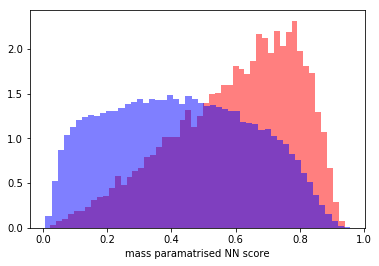

0.22263306796847082


In [21]:
bins =50
y_tr_pred = nnmpmodel.predict(X_tr).ravel()
plt.hist(y_tr_pred[y_tr>0.5].ravel(),alpha=0.5,color='r',bins=bins, density=True)
plt.hist(y_tr_pred[y_tr<0.5].ravel(),alpha=0.5,color='b',bins=bins, density=True)
plt.xlabel("mass paramatrised NN score")
plt.show()
print ( 1.-roc_auc_score(y_tr,y_tr_pred,sample_weight=w_tr))

# BDT stuff

In [40]:
#load training
bdtmpwss=load(path+'massparameterisedBDT_'+region+'_'+trainlabel+'_pipe.joblib')
bdtmpcl= load(path+'massparameterisedBDT_'+region+'_'+trainlabel+'_bdt.joblib')

In [41]:
bdtfd=bdtmpwss.steps[-1][1]

In [42]:
#load data
df_mc=pd.read_hdf('pandas_'+preregion+'.h5',preregion)
htf=HpTrainingFrame.HpTrainingFrame(df_mc)
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=hpmass,region=preregion)
X_train["hpmass"]=hpmass
X_tr, y_tr, w_tr = bdtfd.transform(X_train,y_train,w_train)

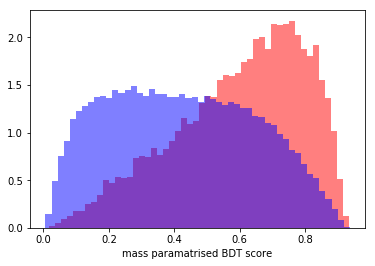

0.21764691841067174


In [49]:
y_tr_pred = bdtmpcl.predict_proba(X_tr)[:,1]
bins =50
plt.hist(y_tr_pred[y_tr>0.5].ravel(),alpha=0.5,color='r',bins=bins, density=True)
plt.hist(y_tr_pred[y_tr<0.5].ravel(),alpha=0.5,color='b',bins=bins, density=True)
plt.xlabel("mass paramatrised BDT score")
plt.show()
print ( 1.-roc_auc_score(y_tr,y_tr_pred,sample_weight=w_tr))